## Two Algorithms:

I have two versions of this algorithm 

1. Using laplace noise for all privacy noise. 
2. Using the google privacy accountant to get parameters for gaussian and discrete laplace noise. 

It would be interesting to see if using the gaussian and dlaplace noise instead makes any significant difference 

### Parameters 

- max_depth: How deep the LSH tree should be constructed
- branching_threshold: Minimum number of nodes required to branch
- include_threshold: Minimum number of nodes required to include in final coreset

Algorithm 1: The split of privacy over constructing tree and private averages (default 0.8/0.2)


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from bucket import create_bucket_synopsis, bucket_using_privacy_accountant, Params
from evaluation_utils import kmeans_loss
from lloyd import lloyd_with_weights
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

master_rng = np.random.default_rng(42)

def lsh_experiment(algo: int, data: np.ndarray, p: Params, n_trials: int = 20):
    s = master_rng.integers(low=0, high=100000)
    total_loss = 0
    n_successful_trials = n_trials
    for x in range(n_trials):
        if algo == 1:
            print("starting synopsis... ")
            private_points, private_weights = create_bucket_synopsis(data, p, s+x)
        else:
            private_points, private_weights = bucket_using_privacy_accountant(data, p, s+x)
        if private_points.shape[0] <= p.k: # if number of points is less than or equal to desired number of centers
            centers = private_points
        else:
            centers = lloyd_with_weights(k=p.k, X=private_points, weights=private_weights, n_iter=5, rs=s+x)
        try:
            loss = kmeans_loss(centers, data)
        except:
            loss = 0
            n_successful_trials -=1
        total_loss += loss
        print(f"Trial {x+1} done")
    print("Number completed trials: ", n_successful_trials)
    return total_loss / n_successful_trials

def non_private_radius(x: np.ndarray) -> float:
    return np.max(np.linalg.norm(x, axis=-1))

plt.style.use('seaborn-v0_8') 


1.1506247348619374
Parameters used 
 max depth: 20
 branching threshold: 138 
 include_threshold: 46
Parameters used 
 max depth: 20
 branching threshold: 138 
 include_threshold: 46
pcalc AveragePrivacyParam(gaussian_standard_deviation=5.205727179479912, sensitivity=1.2) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Algorithm 1 loss: 0.19652620778253835
Algorithm 2 loss: 0.18398534633886365


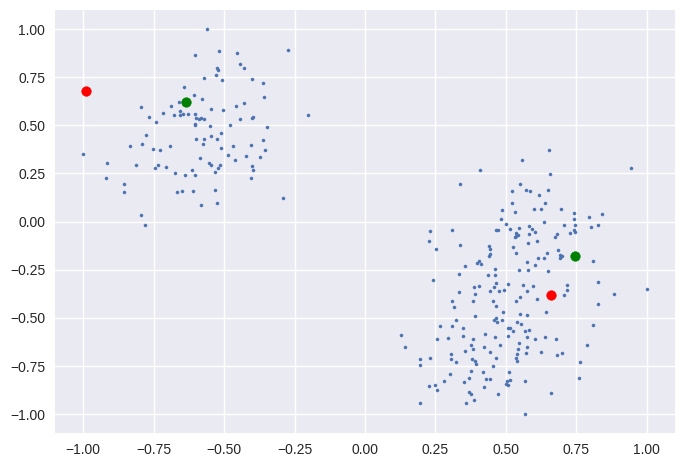

In [2]:
small = np.load("datasets/synthetic-gaussian.npy")
print(non_private_radius(small))
p = Params(epsilon=1, delta=1e-6, radius=1.2, dimension=2, k=3, max_depth=20, include_threshold=46, branching_threshold=138)
points1, weights1 = create_bucket_synopsis(small, p, seed=454)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=454)

# the algorithm only returns 2 points. since we wanted k=3, these points will just become the centers. 
plt.scatter(small[:,0], small[:,1], s=5)
plt.scatter(points1[:,0], points1[:,1], c="red")
plt.scatter(points2[:,0], points2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(points1, small)}")
print(f"Algorithm 2 loss: {kmeans_loss(points2, small)}")

In [4]:
# vary max depth for default branching threshold, include threshold. Note that max depth has to be chosen before computing any noise so it cannot depend on the other parameters

values = [30,40,50,60,70]
results1 = []
results2 = []

for d in values:
    p = Params(epsilon=1, delta=1e-6, radius=1.3, dimension=2, k=3, include_threshold=d, max_depth=10)
    l1 = lsh_experiment(1, small, p, n_trials=50)
    l2 = lsh_experiment(2, small, p, n_trials=50)
    results1.append(l1)
    results2.append(l2)


starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching thresho

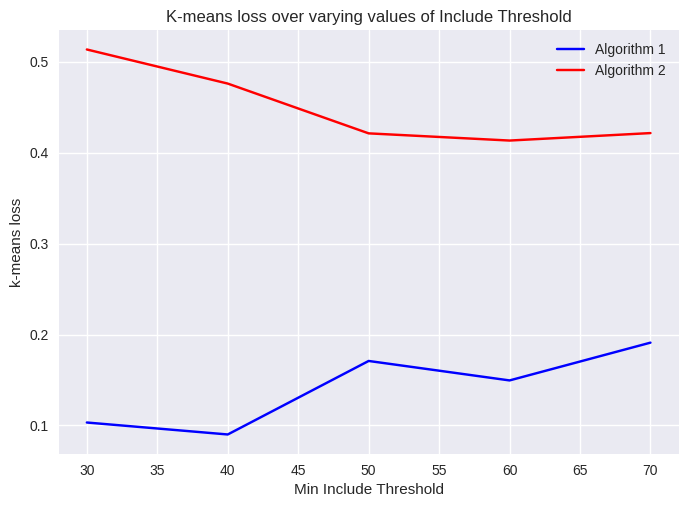

In [5]:
plt.plot(values, results1, c="blue")
plt.plot(values, results2, c="red")
plt.title("K-means loss over varying values of Include Threshold")
plt.xlabel("Min Include Threshold")
plt.ylabel("k-means loss")
plt.legend(["Algorithm 1", "Algorithm 2"])

### Airports Dataset

In [6]:
airports = np.load("datasets/airports.npy")

# find radius of airports dataset
np.max(np.linalg.norm(airports, axis=-1))

np.float64(1.3516862659357243)

Parameters used 
 max depth: 20
 branching threshold: 150 
 include_threshold: 50
Parameters used 
 max depth: 20
 branching threshold: 150 
 include_threshold: 50
pcalc AveragePrivacyParam(gaussian_standard_deviation=6.073348376068814, sensitivity=1.4) CountPrivacyParam(dlaplace_param=0.011525767281163267)
Algorithm 1 loss: 0.0375636027223247
Algorithm 2 loss: 0.048927035064247365


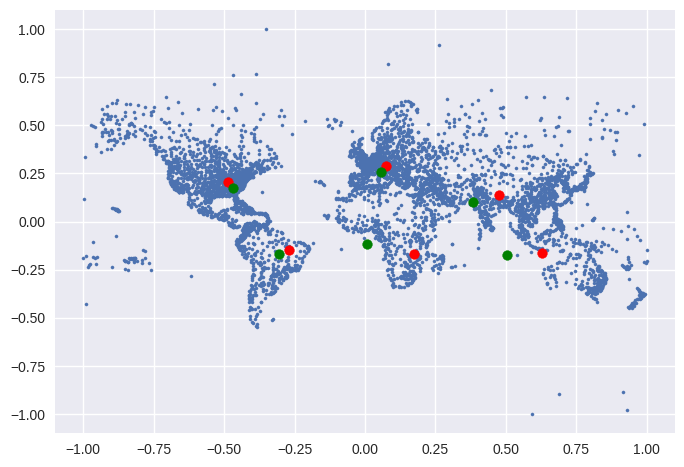

In [14]:
k=6
p = Params(epsilon=1, delta=1e-6, radius=1.4, dimension=2, k=k)
points1, weights1 = create_bucket_synopsis(airports, p, seed=421231)
points2, weights2 = bucket_using_privacy_accountant(airports, p, seed=421231)
if len(points1) > k:
    centers1 = KMeans(k).fit(points1, sample_weight=weights1).cluster_centers_
else:
    centers1 = points1
if len(points2) > k:
    centers2 = KMeans(k).fit(points2, sample_weight=weights2).cluster_centers_
else:
    centers2 = points2

plt.scatter(airports[:,0], airports[:,1], s=5)
plt.scatter(centers1[:,0], centers1[:,1], c="red")
plt.scatter(centers2[:,0], centers2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(centers1, airports)}")
print(f"Algorithm 2 loss: {kmeans_loss(centers2, airports)}")

In [7]:
# vary the value of k 
results1 = []
results2 = []
k_vals = list(range(2,16))

for k in k_vals:
    p = Params(epsilon=1, delta=1e-6, radius=1.4, dimension=2, k=k, max_depth=10)
    results1.append(lsh_experiment(1, airports, p, 50))
    results2.append(lsh_experiment(2, airports, p, 50))

starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 150 
 include_threshold: 50
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching

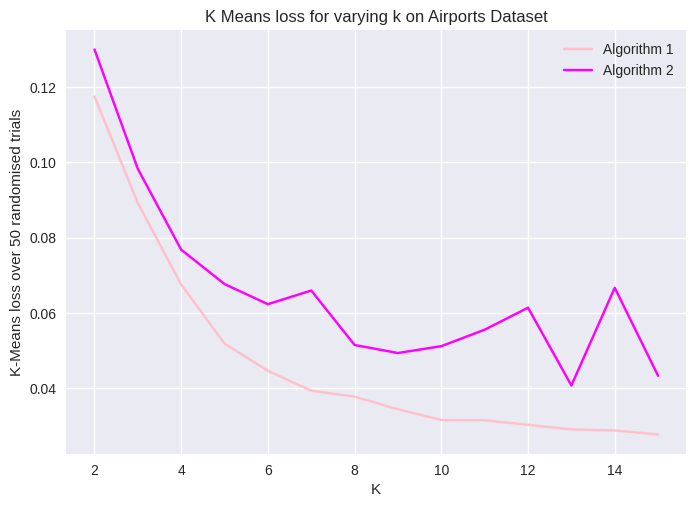

In [8]:
plt.plot(k_vals, results1, c="pink")
plt.plot(k_vals, results2, c="magenta")
plt.title("K Means loss for varying k on Airports Dataset")
plt.xlabel("K")
plt.ylabel("K-Means loss over 50 randomised trials")
plt.legend(["Algorithm 1", "Algorithm 2"])

In [9]:
threshold_vals = [30, 40, 50, 60, 70, 80]
results1 = []
results2 = []

for t in threshold_vals:
    p = Params(epsilon=1, delta=1e-6, radius=1.4, dimension=2, k=6, include_threshold=t, max_depth=10)
    results1.append(lsh_experiment(1, airports, p, 50))
    results2.append(lsh_experiment(2, airports, p, 50))

starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 90 
 include_threshold: 30
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching thresho

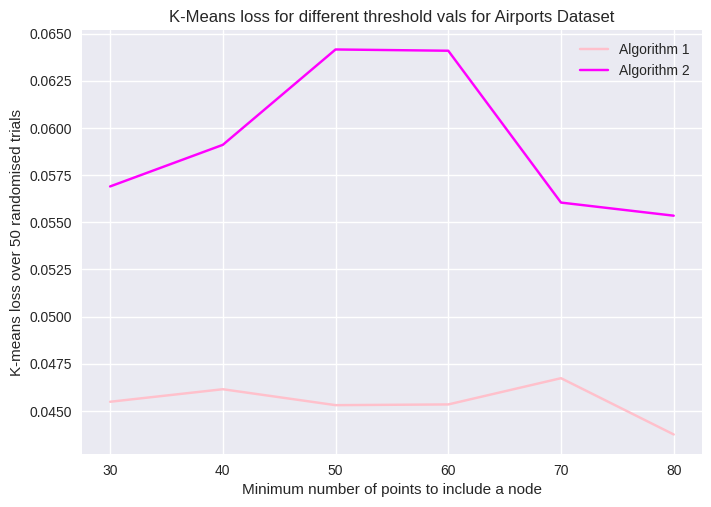

In [10]:
plt.plot(threshold_vals, results1, c="pink")
plt.plot(threshold_vals, results2, c="magenta")
plt.title("K-Means loss for different threshold vals for Airports Dataset")
plt.xlabel("Minimum number of points to include a node")
plt.ylabel("K-means loss over 50 randomised trials")
plt.legend(["Algorithm 1", "Algorithm 2"])

### Iris Dataset

In [11]:

iris = np.load("datasets/iris.npy")

# find the radius of the data
non_private_radius(iris)

np.float64(1.7207934979816446)

Parameters used 
 max depth: 20
 branching threshold: 126.0 
 include_threshold: 42.0


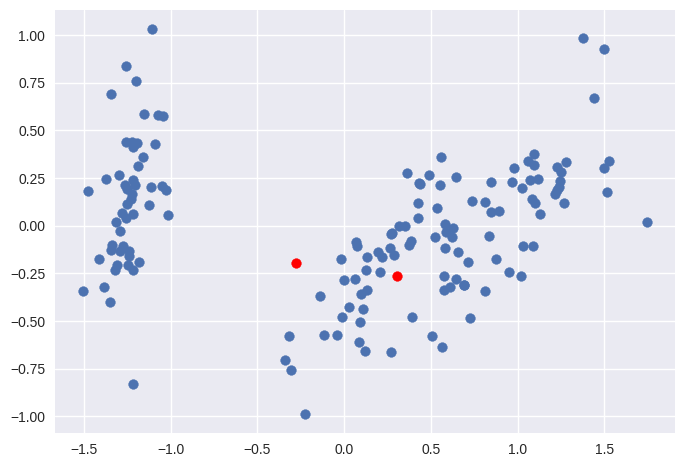

In [12]:
iris_pca = PCA(n_components=2)
iris_2d = iris_pca.fit_transform(iris)

params = Params(epsilon=1, delta=1e-6, radius=1.8, dimension=4, k=2)
points, weights = create_bucket_synopsis(X=iris, p=params, seed=34242)

plt.scatter(iris_2d[:,0], iris_2d[:,1])
plt.scatter(points[:,0], points[:,1], c="red")

In [13]:
results1 = []
results2 = []
k_vals = list(range(2,16))

for k in k_vals:
    p = Params(epsilon=1, delta=1e-6, radius=1.8, dimension=4, k=k, max_depth=5)
    results1.append(lsh_experiment(1, iris, p, 50))
    results2.append(lsh_experiment(2, iris, p, 50))

starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 5
 branching threshold: 114.0 
 include_threshold: 38.0
Trial 8 done
starting synopsis... 
Parameters used 
 

KeyboardInterrupt: 

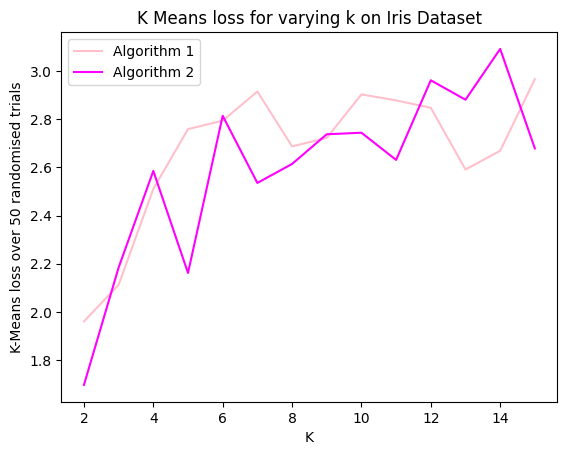

In [38]:
plt.plot(k_vals, results1, c="pink")
plt.plot(k_vals, results2, c="magenta")
plt.title("K Means loss for varying k on Iris Dataset")
plt.xlabel("K")
plt.ylabel("K-Means loss over 50 randomised trials")
plt.legend(["Algorithm 1", "Algorithm 2"])

### Large Synthetic 

In [14]:
large = np.load("datasets/large-synthetic.npy")
large.shape

np.max(np.linalg.norm(large, axis=-1)) # radius of 2.3

np.float64(4.673602230380081)

Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106


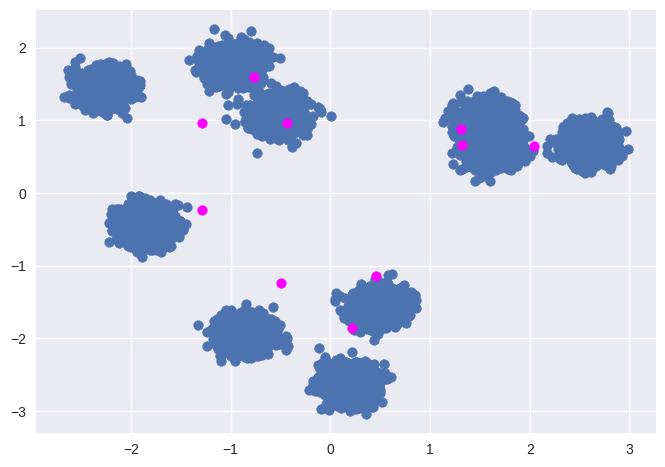

In [15]:
large_pca = PCA(n_components=2)
large_2d = large_pca.fit_transform(large)

params = Params(epsilon=1, delta=1e-6, radius=4.7, dimension=100, k=10)
points, weights = create_bucket_synopsis(X=large, p=params, seed=465)
if len(points) > 10:
    centers = KMeans(10).fit(points, sample_weight=weights).cluster_centers_
else:
    centers = points
centers_2d = large_pca.transform(centers)

plt.scatter(large_2d[:,0], large_2d[:,1])
plt.scatter(centers_2d[:,0], centers_2d[:, 1], c="magenta")

In [16]:
results1 = []
results2 = []
k_vals = list(range(5,21))

for k in k_vals:
    p = Params(epsilon=1, delta=1e-6, radius=4.7, dimension=100, k=k)
    results1.append(lsh_experiment(1, large, p, 100))
    results2.append(lsh_experiment(2, large, p, 100))

starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 318 
 include_threshold: 106
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 20
 b

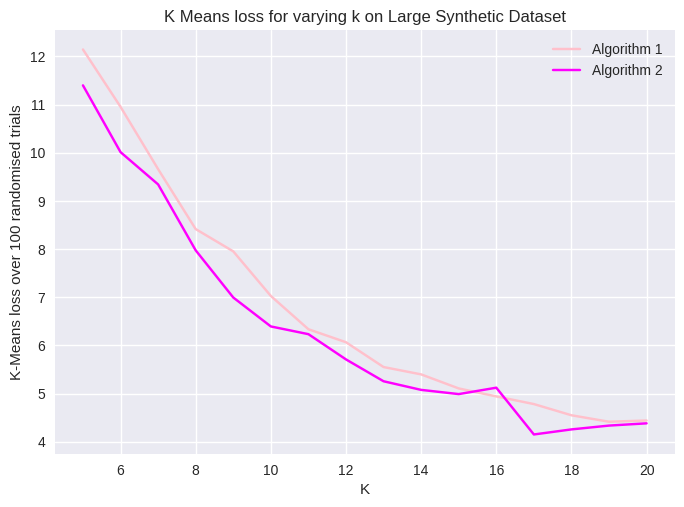

In [17]:
plt.plot(k_vals, results1, c="pink")
plt.plot(k_vals, results2, c="magenta")
plt.title("K Means loss for varying k on Large Synthetic Dataset")
plt.xlabel("K")
plt.ylabel("K-Means loss over 100 randomised trials")
plt.legend(["Algorithm 1", "Algorithm 2"])

In [18]:
forest = np.load("datasets/forest.npy")
print(forest.shape)

np.max(np.linalg.norm(forest, axis=-1)) # radius of 2.3

(10000, 9)


np.float64(2.3357579993966078)

Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
[259.35959421 529.35959421 267.35959421 355.35959421 486.35959421
 530.35959421 356.35959421 552.35959421 566.35959421 447.35959421
 494.35959421 586.35959421 347.35959421 464.35959421 521.35959421
 470.35959421 597.35959421 447.35959421 353.35959421]


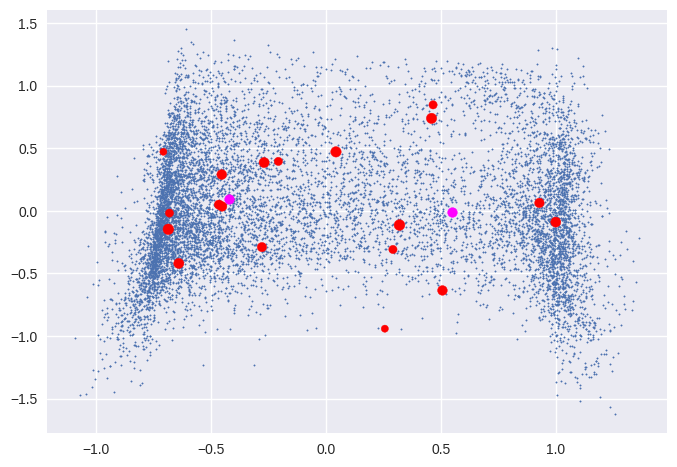

In [20]:
from sklearn.cluster import KMeans

forest_pca = PCA(n_components=2)
forest_2d = forest_pca.fit_transform(forest)

params = Params(epsilon=1, delta=1e-6, radius=2.4, dimension=9, k=2, include_threshold=200)
points, weights = create_bucket_synopsis(X=forest, p=params, seed=21375, privacy_split=0.5)
centers = KMeans(n_clusters=2, init="k-means++").fit(points, sample_weight=weights).cluster_centers_
centers_2d = forest_pca.transform(centers)
points_2d = forest_pca.transform(points)

plt.scatter(forest_2d[:,0], forest_2d[:,1], s=1)
plt.scatter(points_2d[:,0], points_2d[:, 1], s=abs(weights)*0.1, c="red")
plt.scatter(centers_2d[:,0], centers_2d[:, 1], c="magenta")

print(weights)

In [5]:
# how well do the points approximate the data? 
# smaller W1 distances represent closer distributions 

from scipy.stats import wasserstein_distance_nd

forest_weights = np.ones(10000) / 100000

# default for number of trials is low as wasserstein distance is expensive
def lsh_w1(x: np.ndarray, algo: int, p : Params, n_trials=5):
    m = x.shape[0]
    x_weights = np.ones(m) / m
    s = master_rng.integers(low=0, high=100000)
    total_w1 = 0
    for n in range(n_trials):
        if algo == 1:
            points, weights = create_bucket_synopsis(x, p, s+n)
        else:
            points, weights = bucket_using_privacy_accountant(x, p, s+n)
        total_w1 += wasserstein_distance_nd(x, points, x_weights, weights)
    return total_w1 / n_trials
        

#wasserstein_distance_nd(forest, points, np.array([1/10000]*10000), weights) # takes just under 60 seconds to compute 

In [6]:
# first lets do defaults and change epsilon to see if w1 makes sense as a measure 
results = []

for e in range(1,11):
    p = Params(e, 1e-6, 2.4, 9, 2, include_threshold=200)
    res = lsh_w1(forest, 1, p)
    results.append(res)
    print(f"e = {e} gives {res}")

Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
e = 1 gives 1.0158540566072651
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
e = 2 gives 0.798121645489949
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Parameters used 
 max dept

Text(0, 0.5, 'Wasserstein Distance')

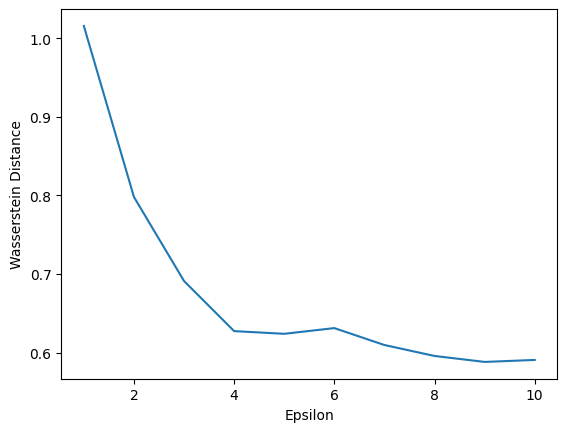

In [8]:
plt.plot(list(range(1,11)), results)
plt.xlabel("Epsilon")
plt.ylabel("Wasserstein Distance")


In [16]:
# try different values of include threshold

thresholds = [200, 225, 250, 300, 400, 500, 600]
results = []

for i in thresholds:
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=9, k=2, include_threshold=i)
    avg_loss = lsh_experiment(algo=1, data=forest, p=p, n_trials=50)
    results.append(avg_loss)

starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 20
 branching threshold: 600 
 include_threshold: 200
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 20
 b

[np.float64(1.116478079577987), np.float64(1.1407056410887424), np.float64(1.0959751267203155), np.float64(1.0622742835053947), np.float64(1.0577344190342046), np.float64(1.0494759867499979), np.float64(1.0349805752084922)]


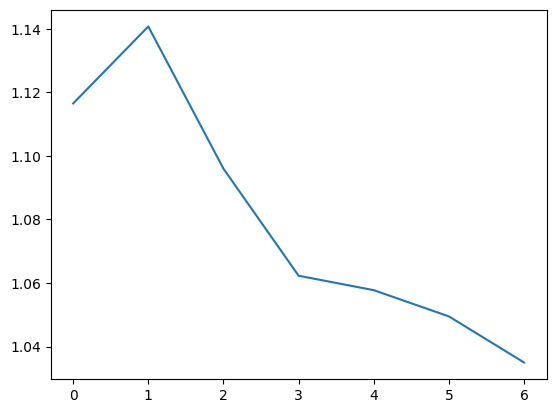

In [17]:
plt.plot(results)
print(results)

### Concrete

In [21]:
concrete = np.load("datasets/concrete.npy")
print(non_private_radius(concrete))
print(concrete.shape)

2.57112624023011
(1030, 8)


Parameters used 
 max depth: 20
 branching threshold: 162 
 include_threshold: 54


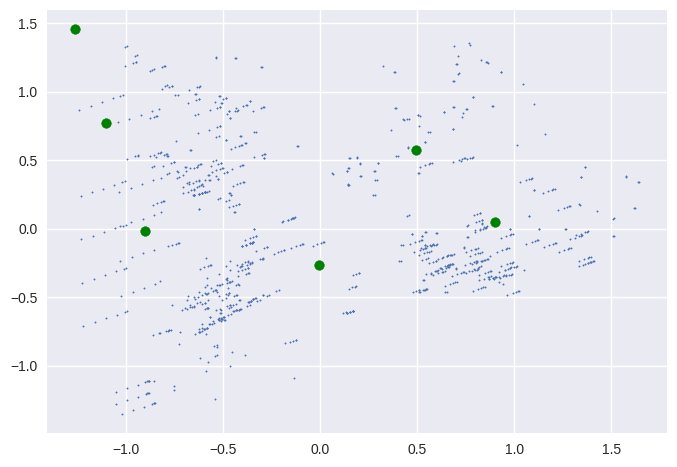

In [22]:
concrete_pca = PCA(n_components=2)
concrete_2d = concrete_pca.fit_transform(concrete)

K=4
p = Params(epsilon=1, delta=1e-6, radius=2.6, dimension=8, k=K)
points, weights = create_bucket_synopsis(concrete, p, seed=5793)

if points.shape[0] > K:
    centers = KMeans(n_clusters=K).fit(points, sample_weight=weights).cluster_centers_
else:
    centers = points 

centers_2d = concrete_pca.transform(centers)
points_2d = concrete_pca.transform(points)

plt.scatter(concrete_2d[:,0], concrete_2d[:,1], s=1)
#plt.scatter(centers_2d[:,0], centers_2d[:,1], c="magenta")
plt.scatter(points_2d[:,0], points_2d[:,1], c="green")


In [27]:


for k in [6,7,8]:
    p = Params(epsilon=1, delta=1e-6, radius=2.6, dimension=8, k=k, max_depth=10)
    l1 = lsh_experiment(1, concrete, p)
    l2 = lsh_experiment(2, concrete, p)
    results1.append(l1)
    results2.append(l2)


starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 1 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 2 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 3 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 4 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 5 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 6 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 7 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching threshold: 162 
 include_threshold: 54
Trial 8 done
starting synopsis... 
Parameters used 
 max depth: 10
 branching

7

Text(0, 0.5, 'Average k-means loss over 20 trials')

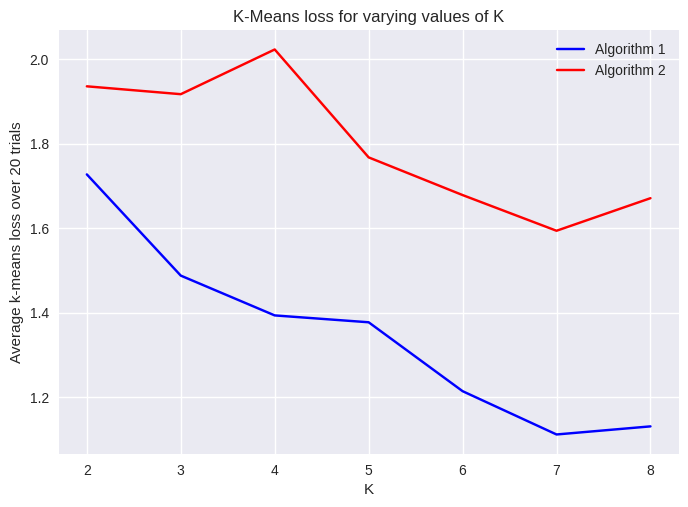

In [29]:
k_vals = [2,3,4,5,6,7,8]
plt.plot(k_vals, results1, c="blue")
plt.plot(k_vals, results2, c="red")
plt.legend(["Algorithm 1", "Algorithm 2"])
plt.title("K-Means loss for varying values of K")
plt.xlabel("K")
plt.ylabel("Average k-means loss over 20 trials")

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler 

gen = np.random.default_rng(78)

x1 = gen.multivariate_normal(np.ones(100), np.identity(100), 10000)

x2 = gen.multivariate_normal(-1*np.ones(100), np.identity(100), 10000)

x = np.concat([x1, x2])
x = MinMaxScaler((-1,1)).fit_transform(x)

p = Params(epsilon=10, delta=1e-6, radius=1, dimension=100, k=2)

points, weights = create_bucket_synopsis(x, p, seed=68724)

centers = lloyd_with_weights(2, points, weights, 10, 23)

KMeans(2).fit(x).cluster_centers_
print(centers)

Parameters used 
 max depth: 20
 branching threshold: 150 
 include_threshold: 50
[[ 2.93047150e-02  8.17538182e-02 -2.05668698e-02  5.20028350e-02
   2.05215798e-01  4.69644518e-02  1.28735333e-02 -1.36740513e-02
  -1.06728017e-01  9.84833397e-02 -8.09277711e-02  4.86935448e-02
   1.15131808e-02  4.22132232e-03 -1.87314314e-01 -1.72579098e-01
  -4.19898327e-02 -6.51023348e-03 -1.23519935e-01  8.43096366e-03
  -1.46619829e-01 -2.73423350e-02  6.18825147e-02 -3.75668111e-02
  -1.25261390e-01 -1.24774086e-01  8.00118142e-02 -4.36465949e-02
  -4.54554038e-02  9.28328864e-02 -1.06236021e-01  1.30091290e-01
   2.87071549e-02  3.51252226e-02  2.81061943e-02  8.86365036e-02
  -4.35984829e-02 -2.98445593e-04  1.79783630e-01  3.68889618e-03
   2.06406616e-02 -1.37601800e-01 -6.71357048e-03  1.94114137e-01
  -2.12478083e-03 -7.41854638e-03  2.31789180e-02  3.82366544e-02
  -5.87881284e-02 -3.13798246e-02 -8.11676826e-03  6.39452582e-02
   2.18126824e-05 -7.83793645e-04  2.37588121e-01 -8.0642646

Parameters used 
 max depth: 20
 branching threshold: 411 
 include_threshold: 137
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
[[-0.31170619 -0.31150987 -0.31574941 -0.29648137 -0.29647113 -0.32847424
  -0.30547118 -0.31206204 -0.30722417 -0.29270889]
 [ 0.31581327  0.30169     0.29218581  0.29686539  0.31815571  0.31357562
   0.32006042  0.30147231  0.31242192  0.3019318 ]]
[[ 0.2867055   0.28628945  0.28752715  0.28827828  0.2855829   0.28673532
   0.28833826  0.28837735  0.28719105  0.28936919]
 [-0.28884448 -0.28833847 -0.28785159 -0.28641883 -0.28818372 -0.2882993
  -0.28744137 -0.28740061 -0.28670743 -0.28600053]]


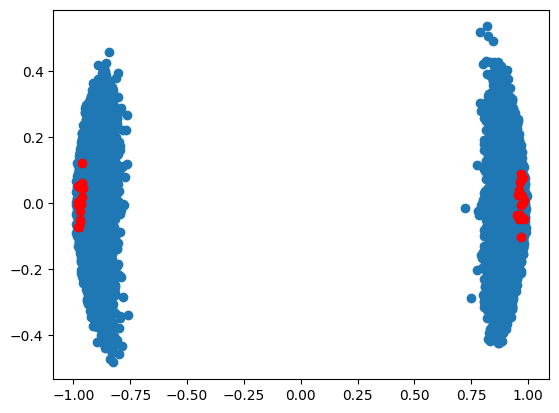

In [13]:
z1 = gen.uniform(low=-1, high=-0.1, size=(10000,10))
z2 = gen.uniform(low=0.1, high=1, size=(10000,10))
z = np.concat([z1, z2])

scale = 1 / np.maximum(
        np.linalg.norm(z, axis=-1), 1
    ).reshape(-1, 1)
z = z * scale

pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)
plt.scatter(z_2d[:,0], z_2d[:,1])

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=10, k=2)
points, weights = bucket_using_privacy_accountant(z, p, seed=2123)
points_2d = pca.transform(points)
plt.scatter(points_2d[:,0], points_2d[:,1], c="red")
points.shape

centers = KMeans(2).fit(points, sample_weight=weights).cluster_centers_
print(centers)

real_centers = KMeans(2).fit(z).cluster_centers_
print(real_centers)

In [12]:
# scale z so it is definitely in that radius

scale = 1 / np.maximum(
        np.linalg.norm(z, axis=-1), 1
    ).reshape(-1, 1)
z_scaled = z * scale

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=10, k=2)
points, weights = bucket_using_privacy_accountant(z_scaled, p, seed=2123)
centers = KMeans(2).fit(points, sample_weight=weights).cluster_centers_
print(centers)

real_centers = KMeans(2).fit(z_scaled).cluster_centers_
print(real_centers)

Parameters used 
 max depth: 20
 branching threshold: 411 
 include_threshold: 137
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
[[ 0.31935227  0.30268037  0.2967799   0.29397793  0.32211033  0.31729504
   0.3211759   0.30029292  0.30448614  0.29820318]
 [-0.30818741 -0.3114068  -0.31329431 -0.30177599 -0.295111   -0.32850661
  -0.30143428 -0.3119433  -0.3077515  -0.29835025]]
[[ 0.28886707  0.287928    0.2880989   0.28818325  0.28781475  0.28900722
   0.28701287  0.28521865  0.28674588  0.28684429]
 [-0.28560289 -0.28732374 -0.28698842 -0.28873711 -0.28779413 -0.28670182
  -0.28597476 -0.28836744 -0.28747737 -0.29075439]]


Parameters used 
 max depth: 20
 branching threshold: 183 
 include_threshold: 61
pcalc AveragePrivacyParam(gaussian_standard_deviation=4.338105982899927, sensitivity=1) CountPrivacyParam(dlaplace_param=0.011525767281180188)
Printing entire non private tree...
level 0 [(20002, '')]
level 1 [(10015, '0'), (9989, '1')]
level 2 [(5661, '00'), (4356, '01'), (4360, '10'), (5631, '11')]
level 3 [(3494, '000'), (2169, '001'), (4356, '010'), (2, '011'), (2, '100'), (4360, '101'), (2156, '110'), (3477, '111')]
level 4 [(3494, '0000'), (2, '0001'), (2, '0010'), (2169, '0011'), (4356, '0100'), (2, '0101'), (2, '1010'), (4360, '1011'), (2156, '1100'), (2, '1101'), (2, '1110'), (3477, '1111')]
level 5 [(3109, '00000'), (387, '00001'), (2, '00110'), (2169, '00111'), (4356, '01000'), (2, '01001'), (2, '10110'), (4360, '10111'), (2156, '11000'), (2, '11001'), (395, '11110'), (3084, '11111')]
level 6 [(2, '000000'), (3109, '000001'), (2, '000010'), (387, '000011'), (2169, '001110'), (2, '001111'), (2, 

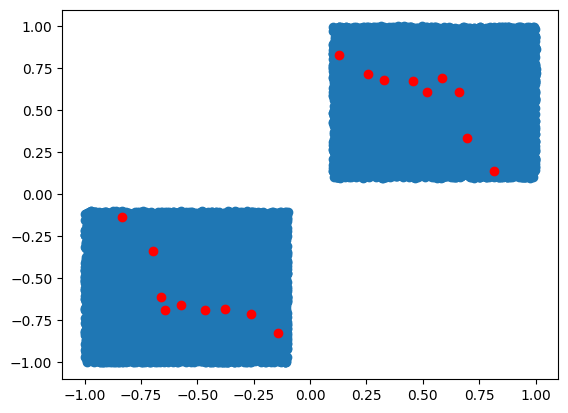

In [21]:
z1 = gen.uniform(low=-1, high=-0.1, size=(10000,2))
z2 = gen.uniform(low=0.1, high=1, size=(10000,2))
z = np.concat([z1, z2])
z_2d = z
plt.scatter(z_2d[:,0], z_2d[:,1])

p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=2)
points, weights = bucket_using_privacy_accountant(z, p, seed=7634)
points_2d = points
plt.scatter(points_2d[:,0], points_2d[:,1], c="red")